In [46]:
__author__ = 'Chien-Hsiu Lee <lee@noao.edu>, Thomas Matheson <matheson@noao.edu>'
__version__ = '20200114' # yyyymmdd
__datasets__ = ['']
__keywords__ = ['ANTARES', 'variable']

# Exploring Elastic Search Database to Find R Corona Borealis Stars

*Chien-Hsiu Lee, Thomas Matheson & ANTARES Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [First chapter](#chapter1)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
This notebook is an example of how to explore the ANTARES alert database for variable stars. Here we use the infrared color selection of candidate R Coronae Borealise stars, and search the ZTF time-series photometry to see if there are unknown R CrBs revealing themselves by a significant, irregular dimming (up to 8 mag).

# Summary
We first obtain the candidate R CrBs from WISE color, selected by Tisserand et al. (2012). We then use the ANTARES search API to find time-series photometry of each candidate, and looked for R CrBs candidates that show more than 2 magnitude variability in either g- or r-band. In the end, we use ZTF18abhjrcf as a showcase.

# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [41]:
#we first call ANTARES libraries
from antares import dev_kit as dk
# Configure connections to the test database.
engine.init()
#Other package to import
from astropy.io import ascii
#import numpy as np
import matplotlib.pyplot as plt


<a class="anchor" id="import"></a>
# Reading in relevant table(s)

In [42]:
#We use the candidate list from Tisserand (2012), dropping candidates below Dec<-30 (in the ZTF field).
#Here we read in the list of candidate, specifically their ra and dec.
tab=ascii.read('WISE_RCrB.dat')
ra, dec = tab['col1'], tab['col2']


<a class="anchor" id="import"></a>
# Querying ANTARES alert database with search API, and search for variabilities larger than 2 mag in either g or r-band.

In [43]:
#This cell shows how to call elastic search. It can be ZTF object id, RA, Dec, or other properties.
from antares_client.search import search
#for i in range(len(ra)): #this line will search for the full candidate list for variability
for i in [228, 229, 230]: #for illustration purpose, we only search variability in three of the candidate 
    print("Iteration: ",i)
    query = {
        "query": {
            "bool": {
                "must": [
                    {
                        "range": {
                            "ra": {
                                "gte": ra[i]-1./3600.,
                                "lte": ra[i]+1./3600.,
                            }
                        }
                    },
                    {
                        "range": {
                            "dec": {
                                "gte": dec[i]-1./3600.,
                                "lte": dec[i]+1./3600.
                            }
                        }
                    }
                 ]
            }
        }
    }
    result_set = search(query)
    rdate=[]
    rmag=[]
    rerr=[]
    gdate=[]
    gmag=[]
    gerr=[]
    
    for i in range(len(result_set)):
        if result_set[i]["survey"] == 1 and len(result_set[i]["properties"])>0 and result_set[i]["properties"]["ztf_fid"] == '1' :
            gdate.append(float(result_set[i]["properties"]["ztf_jd"]))
            gmag.append(float(result_set[i]["properties"]["ztf_magpsf"]))
            gerr.append(float(result_set[i]["properties"]["ztf_sigmapsf"]))
        if result_set[i]["survey"] == 1 and len(result_set[i]["properties"]) > 0 and result_set[i]["properties"]["ztf_fid"] == '2' :
            rdate.append(float(result_set[i]["properties"]["ztf_jd"]))
            rmag.append(float(result_set[i]["properties"]["ztf_magpsf"]))
            rerr.append(float(result_set[i]["properties"]["ztf_sigmapsf"]))
    if len(gmag)>0 and max(gmag)-min(gmag) > 2.: 
        print("Got a hit on locus_id: ",result_set[i]["locus_id"])
    if len(rmag)>0 and max(rmag)-min(rmag) > 2.:
        print("Got a hit on locus_id: ",result_set[i]["locus_id"])




Iteration:  228
Iteration:  229
Got a hit on locus_id:  231020
Iteration:  230
Got a hit on locus_id:  425493


<a class="anchor" id="import"></a>
# Looks like we got a hit. Let's have a look at the last one (locus_id 425493). We first extract relevant properties (MJD, Mag, Mag_err) from the locus.

In [44]:
#extracting light curve related properties
rdate=[]
rmag=[]
rerr=[]
gdate=[]
gmag=[]
gerr=[]

for i in range(len(result_set)):
    if result_set[i]["survey"] == 1 and result_set[i]["properties"]["ztf_fid"] == '1' :
        gdate.append(float(result_set[i]["properties"]["ztf_jd"]))
        gmag.append(float(result_set[i]["properties"]["ztf_magpsf"]))
        gerr.append(float(result_set[i]["properties"]["ztf_sigmapsf"]))
    if result_set[i]["survey"] == 1 and result_set[i]["properties"]["ztf_fid"] == '2' :
        rdate.append(float(result_set[i]["properties"]["ztf_jd"]))
        rmag.append(float(result_set[i]["properties"]["ztf_magpsf"]))
        rerr.append(float(result_set[i]["properties"]["ztf_sigmapsf"]))


<a class="anchor" id="import"></a>
# Having the time-series photometry in hand, we can plot the light curve. Voila, here is a new R CrB star!

<function matplotlib.pyplot.show(*args, **kw)>

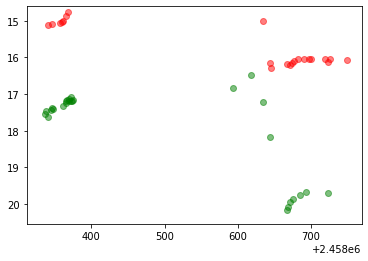

In [45]:
#plot light curve
plt.ylim(max(gmag)+0.1*(max(gmag)-min(gmag)),min(rmag)-0.1*(max(rmag)-min(rmag)))
plt.scatter(rdate, rmag, c='red', alpha=0.5)
plt.scatter(gdate, gmag, c='green', alpha=0.5)
plt.show

# Resources and references
Further reading:

Tisserand (2012) "Tracking down R Coronae Borealis stars from their mid-infrared WISE colours". A&A, 539, 51: https://ui.adsabs.harvard.edu/abs/2012A&A...539A..51T

Tisserand et al. (2013) "The ongoing pursuit of R Coronae Borealis stars: the ASAS-3 survey strikes again". A&A, 551, 22: https://ui.adsabs.harvard.edu/abs/2013A&A...551A..77T